In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [6]:
### Load the dataset and explore the variables

churn=pd.read_csv("customer_churn.csv")
display(churn.head())
churn.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [27]:
### We will try to predict variable Churn using a 
### logistic regression on variables tenure, SeniorCitizen and MonthlyCharges.
### I would guess that we are interested in generating a model that predicts the "Yes" customers
### of the column "churn", which are the customers more likely to leave.

churn = churn[["tenure", "SeniorCitizen", "MonthlyCharges", "Churn"]]
display(churn.head())
churn.info()
churn.shape

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes
3,45,0,42.30,No
4,2,0,70.70,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6566 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          6566 non-null   int64  
 1   SeniorCitizen   6566 non-null   int64  
 2   MonthlyCharges  6566 non-null   float64
 3   Churn           6566 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 256.5+ KB


(6566, 4)

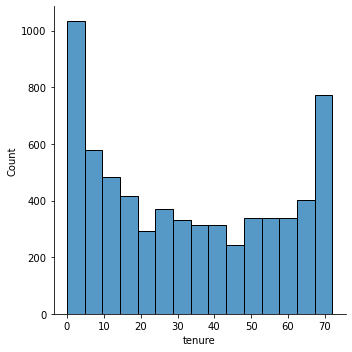

In [32]:
churn["tenure"].value_counts()
sns.displot(churn["tenure"])

### I think here it makes so sense to make a transformation, since the data is relatively
### evenly distibuted 

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

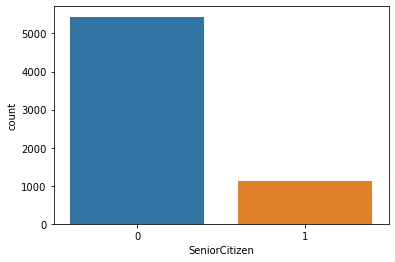

In [31]:
churn["SeniorCitizen"].value_counts()
sns.countplot(x = "SeniorCitizen", data = churn)

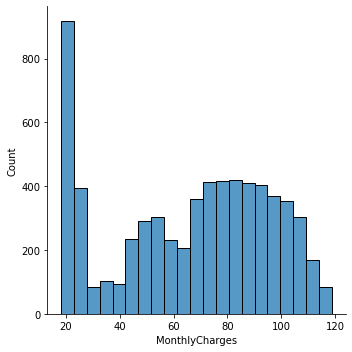

In [30]:
churn["MonthlyCharges"].value_counts()
sns.displot(churn["MonthlyCharges"])

### Here I will also not make a transformation, since the data follows somehow a normal
### distribution, but with a higher abundance of the lower values 

No     4799
Yes    1767
Name: Churn, dtype: int64
The class imbalance ratio is: 0.46  Quite big!


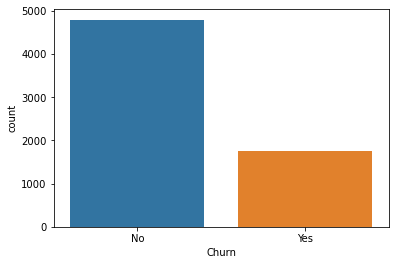

In [33]:
count_classes = churn["Churn"].value_counts()
sns.countplot(x = "Churn", data = churn)
print(count_classes)
print("The class imbalance ratio is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1]))," Quite big!")

### The class imbalance is very big!

In [28]:
print(churn.isna().sum()) ### There are no missing values!
churn = churn.drop_duplicates() ### No duplicates found, since shape remains the same
churn.shape

tenure            0
SeniorCitizen     0
MonthlyCharges    0
Churn             0
dtype: int64


(6566, 4)

In [35]:
### X,y split

y = churn["Churn"]
x = churn.drop(["Churn"], axis = 1)

In [39]:
### Train-test split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 80)
print(x_train.shape)
print(x_test.shape)

(5252, 3)
(1314, 3)


In [43]:
### Normalization by columns of the train set 

transformer = MinMaxScaler().fit(x_train)
x_train_norm = transformer.transform(x_train)
x_train_norm = pd.DataFrame(x_train_norm, columns=x_train.columns)
x_train_norm

,tenure,SeniorCitizen,MonthlyCharges
0,0.569444,1.0,0.758483
1,0.208333,0.0,0.866267
2,0.319444,0.0,0.413673
3,0.416667,0.0,0.009980
4,0.680556,0.0,0.766966
...,...,...,...
5247,1.000000,1.0,0.970060
5248,1.000000,0.0,0.745509
5249,0.944444,0.0,0.637725
5250,0.555556,0.0,0.324850


In [45]:
### Normalization by columns of the test set

transformer = MinMaxScaler().fit(x_test)
x_test_norm = transformer.transform(x_test)
x_test_norm = pd.DataFrame(x_test_norm, columns=x_test.columns)
x_test_norm

,tenure,SeniorCitizen,MonthlyCharges
0,0.180556,1.0,0.269422
1,0.625000,0.0,0.898406
2,0.736111,0.0,0.800299
3,0.125000,1.0,0.715637
4,0.472222,0.0,0.066733
...,...,...,...
1309,1.000000,0.0,0.014940
1310,0.750000,0.0,0.857072
1311,0.791667,0.0,0.403386
1312,0.736111,1.0,0.360558


In [51]:
### Here I am applying the logistic regression model 

lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
lr.fit(x_train_norm, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

In [56]:
### Here I am generating y_train_pred and y_test_pred

y_train_pred = lr.predict(x_train_norm)
y_test_pred  = lr.predict(x_test_norm)

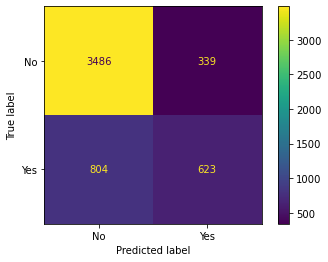

In [60]:
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=classification.classes_);
disp.plot()
plt.show()

### This model is predicting many false negatives (assuming our positive label is "Yes"), but 
### it predicts less false positives 

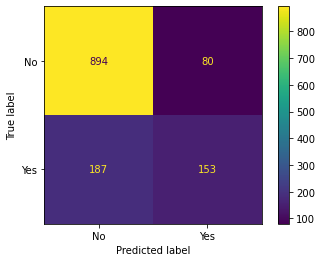

In [62]:
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()
plt.show()

### Because I assume we are interested in knowing which customers are more likely to leave,
### it is very bad to have such a big rate of false negatives, since these are the customers 
### we are interested in targeting. So maybe by correcting the class imbalance we might be 
### able to better predict the TRUE positives as well as reduce the number of false negatives

In [69]:
### The accuracy score is quite high, but the kappa score is not good

print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
print("The precission in the TEST  set is: {:.3f}".format(precision_score(y_test, y_test_pred, pos_label="Yes")))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test, pos_label="Yes")))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test, pos_label="Yes")))
print("The Kappa score in the TEST set is: {:.3f}".format(cohen_kappa_score(y_test, y_test_pred)))

The accuracy in the TEST  set is: 0.797
The precission in the TEST  set is: 0.657
The recall in the TEST set is: 0.45
The F1 in the TEST set is: 0.53
The Kappa score in the TEST set is: 0.410


*Even a simple model will give us more than 70% accuracy. Why?*

We can calculate a baseline accuracy where we will not use a model and instead predict all values to be "No", even if they are not. Here, the number of TP will be 3825 and FP 1427 (These are the numbers of the x_train set: 3825 No, 1427 Yes). For this, the accuracy will be 3825/(3825+1427), which is 72%. 
Even in this extreme case, where we did not use a model and we predicted all the values as "No", the accuracy is higher than 70%.  
I guess it is always good to keep this "baseline" accuracy in mind to see whether our model is performing better.


In [73]:
### Now I am applying SMOTE to see if I can improve the model, by correcting the class imbalance

sm = SMOTE(random_state=100,k_neighbors=3)
x_train_SMOTE,y_train_SMOTE = sm.fit_resample(x_train_norm,y_train)

In [84]:
print(x_train.shape)
print(x_train_SMOTE.shape)
print("Number of values before SMOTE:\n",y_train.value_counts())
print("Number of values after SMOTE:\n",y_train_SMOTE.value_counts())

(5252, 3)
(7650, 3)
Number of values before SMOTE:
 No     3825
Yes    1427
Name: Churn, dtype: int64
Number of values after SMOTE:
 No     3825
Yes    3825
Name: Churn, dtype: int64


In [86]:
### Here I am applying the logistic regression model 

lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
lr.fit(x_train_SMOTE, y_train_SMOTE)

LogisticRegression(multi_class='ovr', random_state=0)

In [88]:
### Here I am generating y_train_pred and y_test_pred

y_train_pred = lr.predict(x_train_SMOTE)
y_test_pred  = lr.predict(x_test_norm)

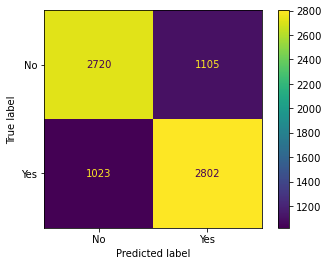

In [90]:
cm_train = confusion_matrix(y_train_SMOTE, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=classification.classes_);
disp.plot()
plt.show()

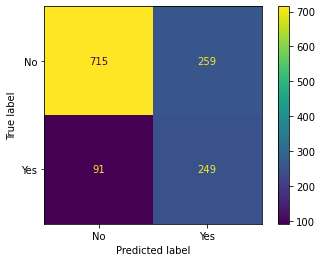

In [92]:
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()
plt.show()

In [93]:
### I am a bit surprised that that model predicts much more false positives in the test 
### than in the train set. Overall, the preformance based on the scores below seems to be worse
### after the SMOTE. 
### HOWEVER, after the SMOTE, the model seems to predict less false negatives and more true positives,
### at the expence that it is predicting more false positives. Since we might be more interested
### in predicting more "Yes" customers, even at the cost that they are false positives, I would 
### still think the model after the SMOTE gives better results (For the purpose of not missing
### customers that might leave: we want to reduce FN and increase TP (even at the expense of FP))

print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
print("The precission in the TEST  set is: {:.3f}".format(precision_score(y_test, y_test_pred, pos_label="Yes")))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test, pos_label="Yes")))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test, pos_label="Yes")))
print("The Kappa score in the TEST set is: {:.3f}".format(cohen_kappa_score(y_test, y_test_pred)))

The accuracy in the TEST  set is: 0.734
The precission in the TEST  set is: 0.490
The recall in the TEST set is: 0.45
The F1 in the TEST set is: 0.53
The Kappa score in the TEST set is: 0.402
